In [1]:
import os
import re

import numpy as np
import pandas as pd
import tables

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, r2_score

from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import SVD, accuracy
from surprise import KNNBasic

In [3]:
from gensim.models import FastText

from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Embedding, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from tensorflow.keras import regularizers

from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.utils import plot_model

2023-04-30 13:47:08.390460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
taste_profile_df = pd.read_csv('/home/016709732/dataset/train_triplets.txt', sep='\t', header=None, names = ['user_id','song_id','play_count'])
taste_profile_df.shape

(48373586, 3)

In [5]:
taste_profile_df.head(8)

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBNZDC12A6D4FC103,1
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1


In [6]:
taste_profile_df.isnull().sum()

user_id       0
song_id       0
play_count    0
dtype: int64

In [7]:
taste_profile_df.duplicated().sum()

0

In [8]:
song_data_df = tables.open_file("/home/016709732/dataset/msd_summary_file.h5", mode="r")
song_data_table = song_data_df.root.metadata.songs
metadata_table_df = pd.DataFrame.from_records(song_data_table[:])
metadata_table_df.shape

(1000000, 20)

In [9]:
metadata_table_df.drop(columns =['analyzer_version', 'artist_7digitalid','artist_id', 'idx_artist_terms','idx_similar_artists','release_7digitalid','artist_location','artist_longitude','artist_latitude','artist_playmeid','track_7digitalid','artist_mbid'],inplace=True)
metadata_table_df.replace({b'': np.nan}, inplace=True)
print(metadata_table_df.isna().sum())
metadata_table_df.drop(columns =['genre'],inplace=True)

artist_familiarity        185
artist_hotttnesss          12
artist_name                 0
genre                 1000000
release                     0
song_hotttnesss        418035
song_id                     0
title                      15
dtype: int64


In [10]:
metadata_table_df = metadata_table_df.applymap(lambda x: x.decode('utf-8').strip('\'"') if isinstance(x, bytes) else x)
metadata_table_df.head(8)

,artist_familiarity,artist_hotttnesss,artist_name,release,song_hotttnesss,song_id,title
0,0.649822,0.394032,Faster Pussy cat,Monster Ballads X-Mas,0.542899,SOQMMHC12AB0180CB8,Silent Night
1,0.439604,0.356992,Karkkiautomaatti,Karkuteillä,0.299877,SOVFVAK12A8C1350D9,Tanssi vaan
2,0.643681,0.437504,Hudson Mohawke,Butter,0.617871,SOGTUKN12AB017F4F1,No One Could Ever
3,0.448501,0.372349,Yerba Brava,De Culo,NaN,SOBNYVR12A8C13558C,Si Vos Querés
4,0.000000,0.000000,Der Mystic,Rene Ablaze Presents Winter Sessions,NaN,SOHSBXH12A8C13B0DF,Tangle Of Aspens
5,0.361287,0.109626,David Montgomery,Berwald: Symphonies Nos. 1/2/3/4,NaN,SOZVAPQ12A8C13B63C,"Symphony No. 1 G minor ""Sinfonie Serieuse""/All..."
6,0.692923,0.453732,Sasha / Turbulence,Strictly The Best Vol. 34,NaN,SOQVRHI12A6D4FB2D7,We Have Got Love
7,0.588156,0.401092,Kris Kross,Da Bomb,NaN,SOEYRFT12AB018936C,2 Da Beat Ch'yall


In [11]:
track_metadata = pd.read_csv('/home/016709732/dataset/track_metadata.csv')
track_metadata.shape

(1000000, 14)

In [12]:
track_metadata.drop(columns =['track_id', 'title','release', 'artist_id','artist_mbid','artist_name','artist_familiarity','artist_hotttnesss','year', 'track_7digitalid','shs_perf','shs_work'], inplace=True)

In [13]:
track_metadata = track_metadata.drop(track_metadata[track_metadata.duration > 480].index)
track_metadata = track_metadata.drop(track_metadata[track_metadata.duration < 60].index)

scaler = MinMaxScaler()
track_metadata['duration'] = scaler.fit_transform(track_metadata[['duration']])

In [14]:
track_metadata.drop_duplicates(inplace=True)
track_metadata.shape

(942370, 2)

In [15]:
track_metadata.head(8)

,song_id,duration
0,SOQMMHC12AB0180CB8,0.457271
1,SOVFVAK12A8C1350D9,0.229879
2,SOGTUKN12AB017F4F1,0.188021
3,SOBNYVR12A8C13558C,0.202513
6,SOQVRHI12A6D4FB2D7,0.362794
7,SOEYRFT12AB018936C,0.383816
8,SOPMIYT12A6D4F851E,0.188518
9,SOJCFMH12A8C13B0C2,0.105921


In [16]:
track_merge = pd.merge(track_metadata, taste_profile_df, on='song_id', how="right")
track_merge.shape

(49266338, 4)

In [17]:
song_data = pd.merge(metadata_table_df, track_merge, on='song_id', how="right")
song_data.shape

(51543725, 10)

In [18]:
song_data = song_data.dropna()
song_data.drop_duplicates(inplace=True)
song_data.shape

(43008308, 10)

In [19]:
count = 0
records = song_data[song_data['play_count'] > 10]
for index, row in records.iterrows():
    count = count + 1
print("play_count after filtering: ", count)

song_data = song_data.drop(song_data[song_data.play_count > 10].index)
song_data['play_count'] = song_data['play_count'].apply(lambda x: 6 if 5 < x <= 8 else 7 if x > 8 else x)
song_data.shape

play_count after filtering:  1774177


(41234131, 10)

In [20]:
print("Columns and the datatypes in the data: \n", song_data.dtypes)
print("\n\nSummary of column statistics: \n", song_data.describe())

Columns and the datatypes in the data: 
 artist_familiarity    float64
artist_hotttnesss     float64
artist_name            object
release                object
song_hotttnesss       float64
song_id                object
title                  object
duration              float64
user_id                object
play_count              int64
dtype: object


Summary of column statistics: 
        artist_familiarity  artist_hotttnesss  song_hotttnesss      duration  \
count        4.123413e+07       4.123413e+07     4.123413e+07  4.123413e+07   
mean         7.436042e-01       5.587681e-01     6.913306e-01  4.268015e-01   
std          1.246091e-01       1.407483e-01     1.946526e-01  1.566630e-01   
min          0.000000e+00       0.000000e+00     0.000000e+00  0.000000e+00   
25%          6.653222e-01       4.658049e-01     5.920326e-01  3.311979e-01   
50%          7.669583e-01       5.413833e-01     7.150432e-01  4.096903e-01   
75%          8.388860e-01       6.143460e-01     8.219409e

In [21]:
song_data = song_data.drop(song_data[song_data.artist_familiarity > 0.85].index)
song_data = song_data.drop(song_data[song_data.artist_familiarity < 0.65].index)

song_data = song_data.drop(song_data[song_data.artist_hotttnesss > 0.62].index)
song_data = song_data.drop(song_data[song_data.artist_hotttnesss < 0.45].index)

song_data = song_data.drop(song_data[song_data.song_hotttnesss > 0.85].index)
song_data = song_data.drop(song_data[song_data.song_hotttnesss < 0.58].index)

song_data = song_data.drop(song_data[song_data.duration > 0.55].index)
song_data = song_data.drop(song_data[song_data.duration < 0.25].index)

song_data.shape

(8075429, 10)

In [22]:
song_data = song_data.reset_index(drop=True)

In [23]:
song_data['unencoded_sid'] = song_data['song_id']
song_data['unencoded_uid'] = song_data['user_id']

In [24]:
data_encoder = LabelEncoder()
song_data['song_id'] = data_encoder.fit_transform(song_data['song_id'])
song_data['user_id'] = data_encoder.fit_transform(song_data['user_id'])

In [25]:
song_dict = dict(zip(song_data['unencoded_sid'], song_data['song_id']))
user_dict = dict(zip(song_data['unencoded_uid'], song_data['user_id']))
song_data.drop(columns =['unencoded_sid'], inplace=True)
song_data.drop(columns =['unencoded_uid'], inplace=True)
song_data.head(8)

,artist_familiarity,artist_hotttnesss,artist_name,release,song_hotttnesss,song_id,title,duration,user_id,play_count
0,0.675339,0.499641,Josh Rouse,Under Cold Blue Stars,0.645846,1865,Ears To The Ground (Album Version),0.264710,638875,1
1,0.675339,0.509058,Josh Rouse,Under Cold Blue Stars,0.643471,4372,Nothing Gives Me Pleasure,0.324605,638875,1
2,0.710446,0.540631,Gipsy Kings,The Best Of,0.778549,4972,Soy,0.309056,638875,1
3,0.675339,0.509058,Josh Rouse,Nashville,0.734343,5321,Winter In The Hamptons,0.305884,638875,1
4,0.675339,0.509058,Josh Rouse,The Best Of The Rykodisc Years,0.705079,6522,My Love Has Gone,0.473504,638875,1
5,0.675339,0.509058,Josh Rouse,Country Mouse_ City House,0.616917,8847,Pilgrim,0.481403,638875,1
6,0.806208,0.498077,Eric Hutchinson,Sounds Like This,0.661073,8933,Outside Villanova (Album Version),0.465916,638875,1
7,0.675339,0.509058,Josh Rouse,Country Mouse_ City House,0.602120,11040,Nice To Fit In,0.354086,638875,1


In [26]:
print("Total number of unique artists: ", len(song_data['artist_name'].unique()))
print("Total number of unique releases/album names: ", len(song_data['release'].unique()))
print("Total number of unique song titles: ", len(song_data['title'].unique()))
print("Total number of unique songs: ", len(song_data['song_id'].unique()))
print("Total number of unique users: ", len(song_data['user_id'].unique()))

Total number of unique artists:  3175
Total number of unique releases/album names:  8864
Total number of unique song titles:  24284
Total number of unique songs:  25992
Total number of unique users:  888884


In [27]:
print("Top 20 active songs from taste profile subset: ")
top_songs = taste_profile_df.groupby(['song_id'])['play_count'].sum().sort_values(ascending=False)[:20]
print(top_songs)

print("\n\nTop 20 active users from taste profile subset: ")
top_users =taste_profile_df.groupby(['user_id'])['play_count'].sum().sort_values(ascending=False)[:20]
print(top_users)

Top 20 active songs from taste profile subset: 
song_id
SOBONKR12A58A7A7E0    726885
SOAUWYT12A81C206F1    648239
SOSXLTC12AF72A7F54    527893
SOFRQTD12A81C233C0    425463
SOEGIYH12A6D4FC0E3    389880
SOAXGDH12A8C13F8A1    356533
SONYKOW12AB01849C9    292642
SOPUCYA12A8C13A694    274627
SOUFTBI12AB0183F65    268353
SOVDSJC12A58A7A271    244730
SOOFYTN12A6D4F9B35    241669
SOHTKMO12AB01843B0    236494
SOBOUPA12A6D4F81F1    225652
SODJWHY12A8C142CCE    209212
SOLFXKT12AB017E3E0    197181
SOTCMDJ12A6D4F8528    192884
SOFLJQZ12A6D4FADA6    185653
SOTWNDJ12A8C143984    174080
SOUNZHU12A8AE47481    158636
SOUVTSM12AC468F6A7    155717
Name: play_count, dtype: int64


Top 20 active users from taste profile subset: 
user_id
093cb74eb3c517c5179ae24caf0ebec51b24d2a2    13132
119b7c88d58d0c6eb051365c103da5caf817bea6     9884
3fa44653315697f42410a30cb766a4eb102080bb     8210
a2679496cd0af9779a92a13ff7c6af5c81ea8c7b     7015
d7d2d888ae04d16e994d6964214a1de81392ee04     6494
4ae01afa8f2430ea0704d502b

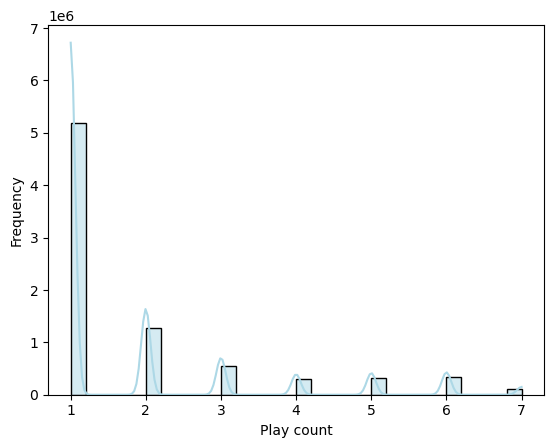

In [28]:
fig, axs = figsize=(8, 8)
sns.histplot(song_data['play_count'], kde=True, 
             bins=int(30), color = 'lightblue', 
             edgecolor='black',
             linewidth=1)
plt.xlabel('Play count')
plt.ylabel('Frequency')
plt.show()

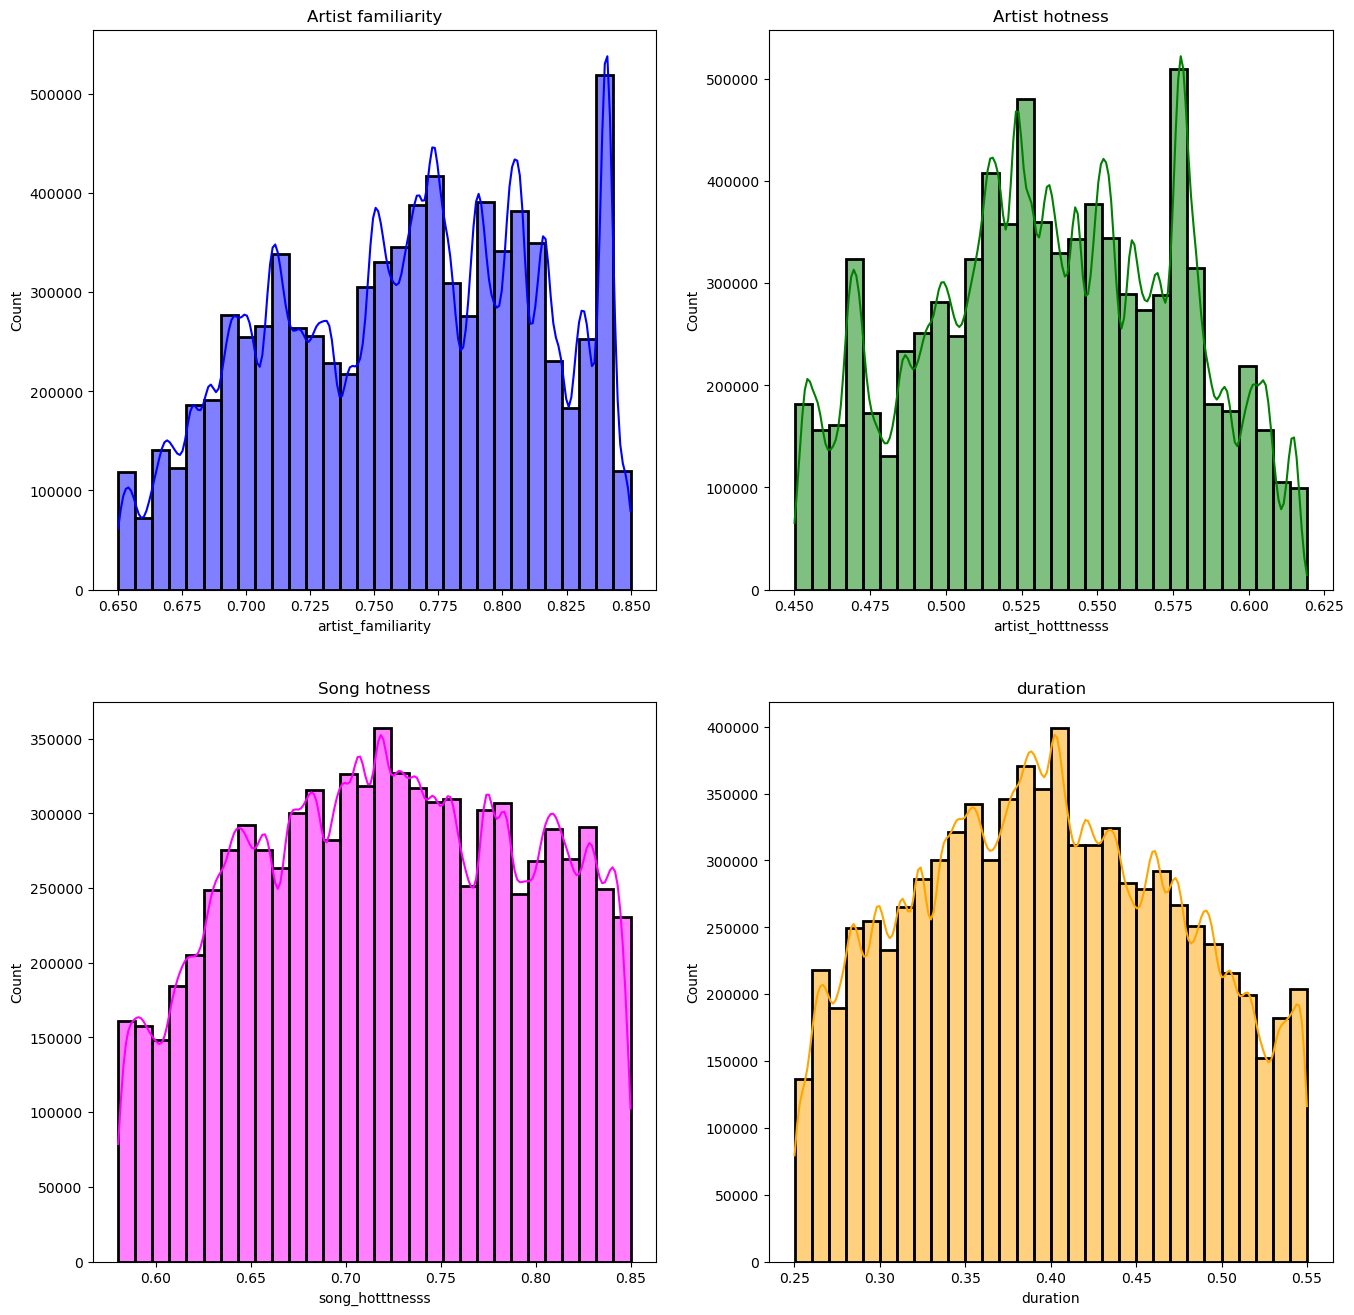

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

sns.histplot(song_data['artist_familiarity'], kde=True, 
             bins=int(30), color = 'blue', 
             edgecolor='black',
             linewidth=2, ax=axs[0][0])
axs[0][0].set_title('Artist familiarity')

sns.histplot(song_data['artist_hotttnesss'], kde=True, 
             bins=int(30), color = 'green', 
             edgecolor='black',
             linewidth=2, ax=axs[0][1])
axs[0][1].set_title('Artist hotness')

sns.histplot(song_data['song_hotttnesss'], kde=True, 
             bins=int(30), color = 'magenta', 
             edgecolor='black',
             linewidth=2, ax=axs[1][0])
axs[1][0].set_title('Song hotness')

sns.histplot(song_data['duration'], kde=True, 
             bins=int(30), color = 'orange', 
             edgecolor='black',
             linewidth=2, ax=axs[1][1])
axs[1][1].set_title('duration')

plt.show()

Text(0.5, 1.0, 'play_count')

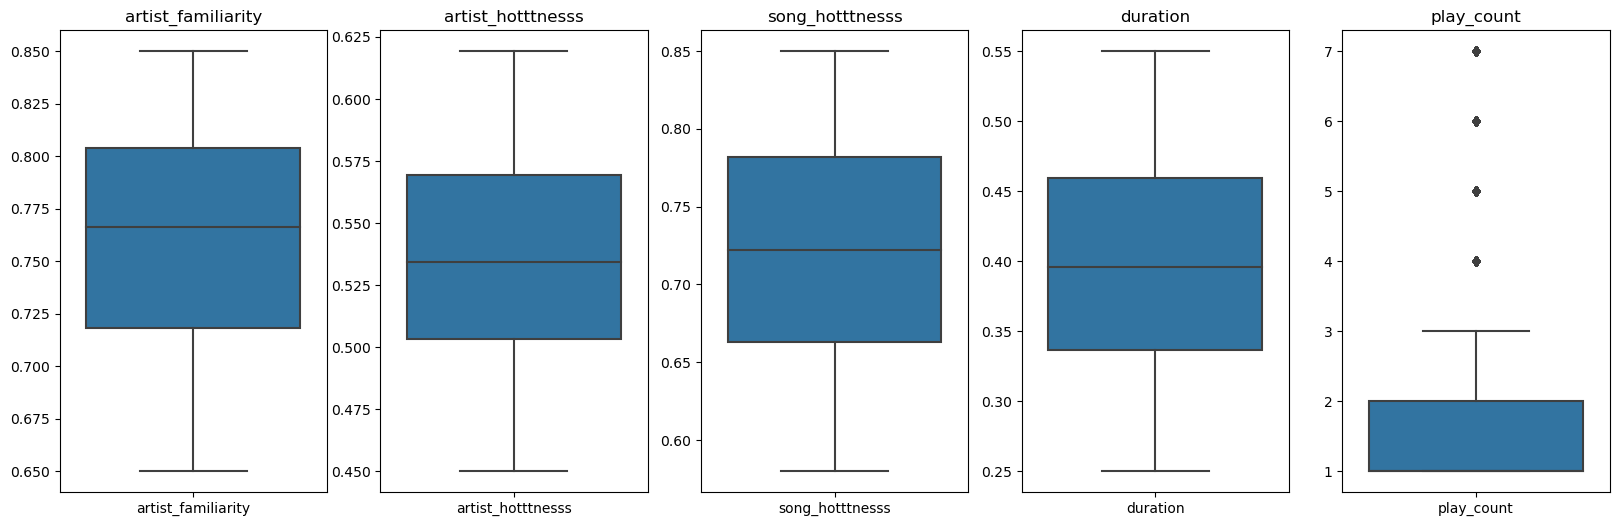

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))

sns.boxplot(data=song_data[['artist_familiarity']], ax=axs[0])
axs[0].set_title('artist_familiarity')

sns.boxplot(data=song_data[['artist_hotttnesss']], ax=axs[1])
axs[1].set_title('artist_hotttnesss')

sns.boxplot(data=song_data[['song_hotttnesss']], ax=axs[2])
axs[2].set_title('song_hotttnesss')

sns.boxplot(data=song_data[['duration']], ax=axs[3])
axs[3].set_title('duration')

sns.boxplot(data=song_data[['play_count']], ax=axs[4])
axs[4].set_title('play_count')

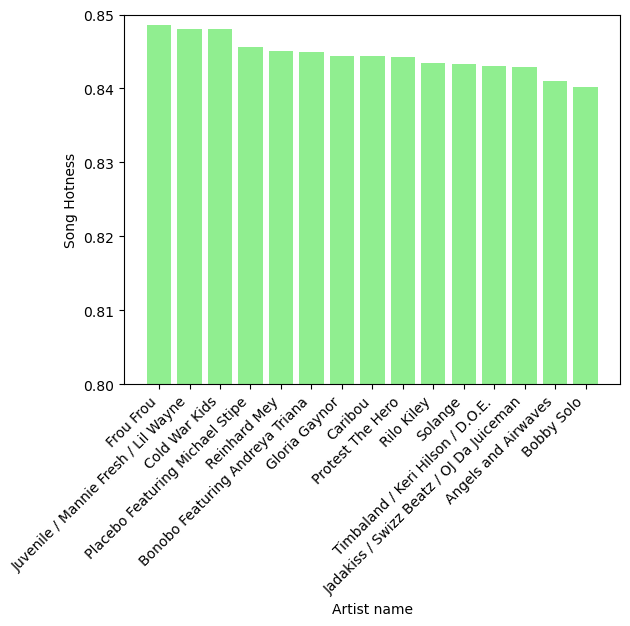

In [31]:
top_albums = song_data.groupby(['artist_name'])['song_hotttnesss'].mean().sort_values(ascending=False)[:15]
plt.ylim(0.8, 0.85)
plt.bar(top_albums.index, top_albums.values, color='lightgreen')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Artist name')
plt.ylabel('Song Hotness')
plt.show()

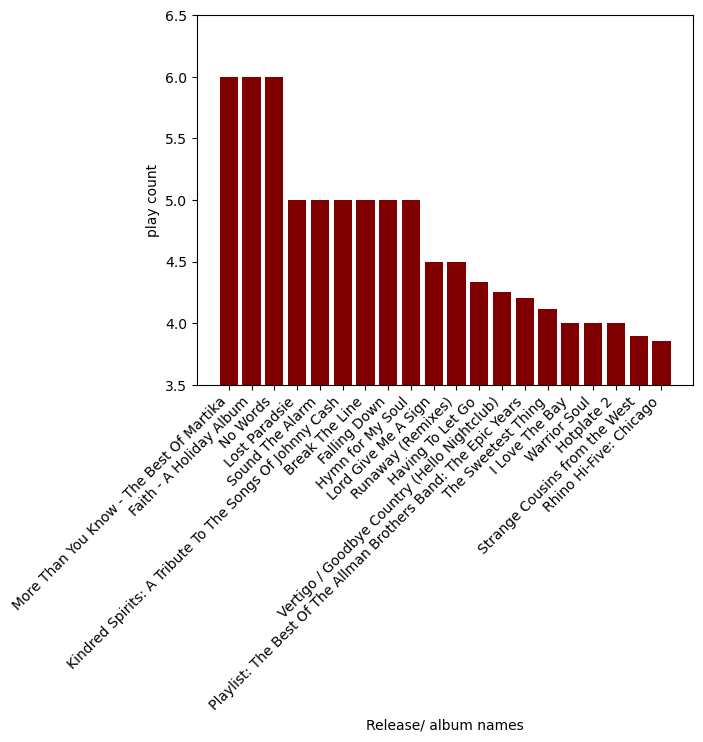

In [32]:
top_artists = song_data.groupby(['release'])['play_count'].mean().sort_values(ascending=False)[:20]
plt.ylim(3.5, 6.5)
plt.bar(top_artists.index, top_artists.values, color='maroon')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Release/ album names')
plt.ylabel('play count')
plt.show()

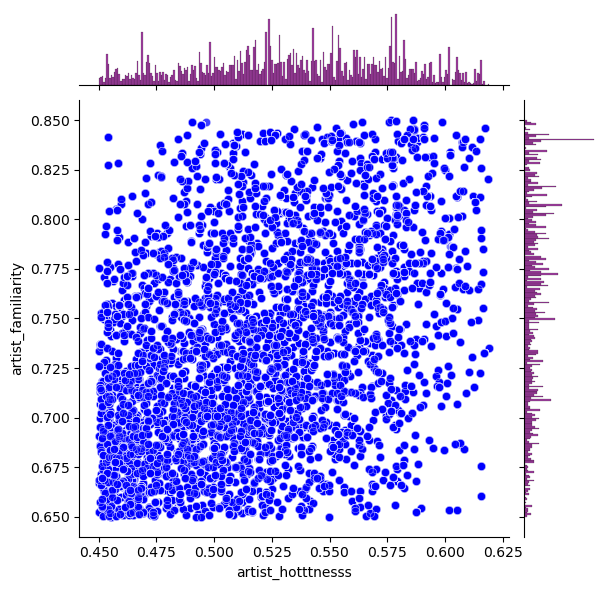

In [33]:
sns.jointplot(x = song_data['artist_hotttnesss'], y = song_data['artist_familiarity'], kind = 'scatter', alpha = 0.5, color = 'blue', marginal_kws = {'color': 'purple'})
plt.show()

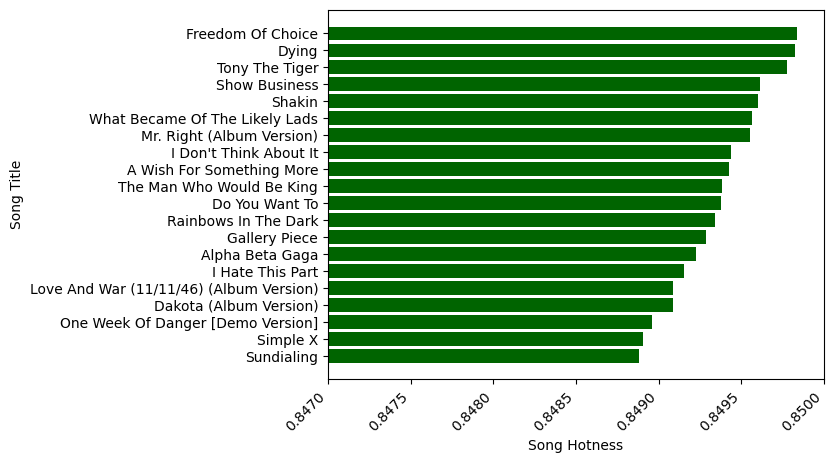

In [34]:
top_songs = song_data.groupby(['title'])['song_hotttnesss'].mean().sort_values(ascending=False)[:20]
plt.gca().invert_yaxis()
plt.xlim(0.847, 0.85)
plt.barh(top_songs.index, top_songs.values, color="darkgreen")
plt.xticks(rotation=45, ha='right')
plt.xlabel('Song Hotness')
plt.ylabel('Song Title')
plt.show()

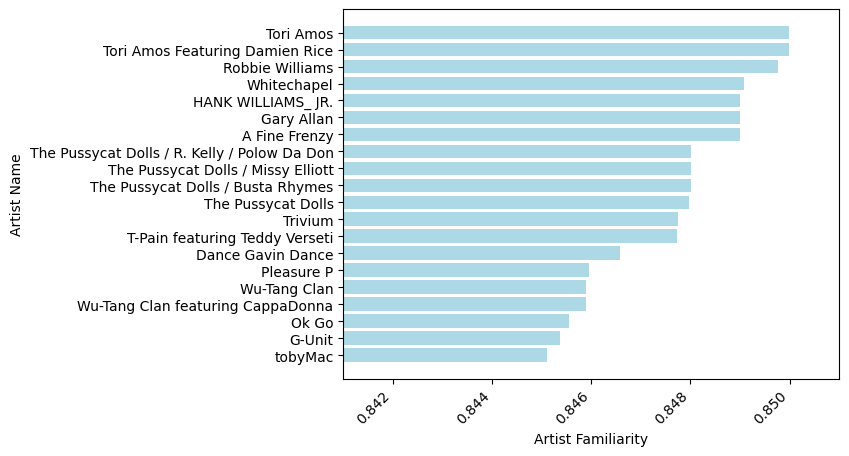

In [35]:
top_artists = song_data.groupby(['artist_name'])['artist_familiarity'].mean().sort_values(ascending=False)[:20]
plt.gca().invert_yaxis()
plt.xlim(0.841, 0.851)
plt.barh(top_artists.index, top_artists.values, color="lightblue")
plt.xticks(rotation=45, ha='right')
plt.xlabel('Artist Familiarity')
plt.ylabel('Artist Name')
plt.show()

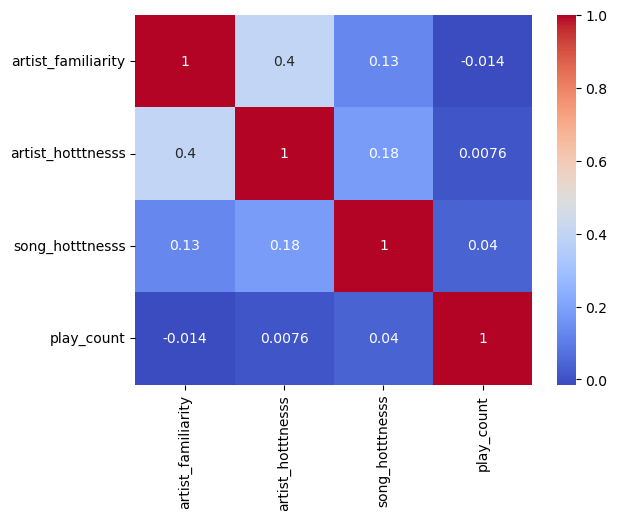

In [36]:
corr = song_data[['artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'play_count']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [37]:
reader = Reader(rating_scale=(1, 7))
songdata = Dataset.load_from_df(song_data[['user_id', 'song_id', 'play_count']], reader)

In [38]:
param_grid = {'n_factors': [2, 3],      
              'n_epochs': [15, 20], 
              'lr_all': [0.007, 0.008], 
              'reg_all': [0.1, 0.2]}

grid_search = GridSearchCV(SVD,         
                           param_grid, 
                           measures=['rmse'], 
                           cv = 3,
                           n_jobs = -1, 
                           refit = True,
                           joblib_verbose = 1
                          )

grid_search.fit(songdata)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  48 | elapsed:  6.1min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  7.6min finished


In [39]:
best_params = grid_search.best_params 
best_params

{'rmse': {'n_factors': 3, 'n_epochs': 20, 'lr_all': 0.008, 'reg_all': 0.1}}

In [40]:
from surprise.model_selection import train_test_split
train_set, test_set = train_test_split(songdata, test_size=0.1, random_state=42)
svd = SVD(n_factors= 2, n_epochs=20, lr_all= 0.008, reg_all= 0.1, init_mean= 0, init_std_dev= 0.001)
svd.fit(train_set)

In [41]:
svd_predictions = svd.test(test_set)
accuracy.rmse(svd_predictions)

RMSE: 1.3485


1.3484602847809182

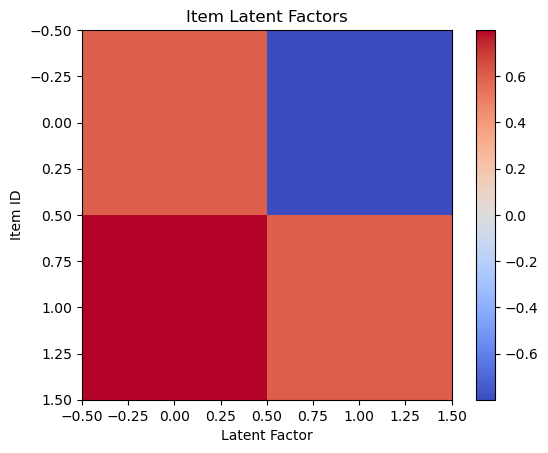

In [42]:
U, S, Vt = np.linalg.svd(svd.pu, full_matrices=False)
plt.imshow(Vt.T, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xlabel('Latent Factor')
plt.ylabel('Item ID')
plt.title('Item Latent Factors')
plt.show()

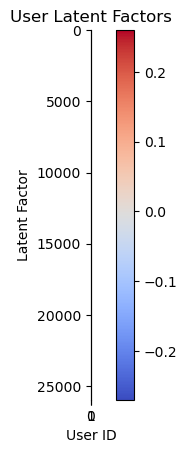

In [43]:
U, S, Vt = np.linalg.svd(svd.qi, full_matrices=False)
plt.imshow(U, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xlabel('User ID')
plt.ylabel('Latent Factor')
plt.title('User Latent Factors')
plt.show()

In [44]:
trainset = songdata.build_full_trainset()
svdc = SVD(n_factors= 2, n_epochs=20, lr_all= 0.008, reg_all= 0.1, init_mean= 0, init_std_dev= 0.001)
svdc.fit(trainset)
predictions = svdc.test(test_set)

In [45]:
song_data['title'] = song_data['title'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
song_data['title'] = song_data['title'].apply(lambda x: x.lower())

song_data['artist_name'] = song_data['artist_name'].apply(lambda x: str(x).lower())
song_data['artist_name'] = song_data['artist_name'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))

song_data['release'] = song_data['release'].apply(lambda x: str(x).lower())
song_data['release'] = song_data['release'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))

In [46]:
svd_song_data = song_data
playcount_pred = []
for i in range(len(svd_song_data)):
  playcount_pred.append(svdc.predict(svd_song_data["user_id"][i], svd_song_data["song_id"][i]).est)
svd_song_data['playcount_pred'] = playcount_pred

In [47]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(svd_song_data, test_size=0.1, random_state=42)

In [48]:
inputs = ['user_id', 'song_id', 'artist_name', 'title', 'release', 'duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']
target = ['play_count']

train_input = train_data[inputs].copy()
train_target = train_data[target]

inputs = ['user_id', 'song_id', 'artist_name', 'title', 'release', 'duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']
target = ['play_count']

test_input = test_data[inputs].copy()
test_target = test_data[target]

text_data = ['artist_name', 'title', 'release']
meta_text = train_data[text_data].copy()

test_text_data = ['artist_name', 'title', 'release']
test_meta_text = test_data[test_text_data].copy()

train_input.shape, meta_text.shape, test_input.shape, test_meta_text.shape

((7267886, 10), (7267886, 3), (807543, 10), (807543, 3))

In [49]:
meta_text['text'] = meta_text.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
corpus = [text.split() for text in meta_text['text']]
emb_size = 30
model_ft = FastText(sentences=corpus, vector_size=emb_size, window=5, min_count=1, workers=4, sg=0)

test_meta_text['text'] = test_meta_text.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
corpus = [text.split() for text in test_meta_text['text']]
emb_size = 30
test_model_ft = FastText(sentences=corpus, vector_size=emb_size, window=5, min_count=1, workers=4, sg=0)

text_vector = []
for text in meta_text['text']:
    vec = np.zeros(emb_size)
    tokens = text.split()
    for token in tokens:
        if token in model_ft.wv:
            vec += model_ft.wv[token]
    text_vector.append(vec)
    
text_vector = np.array(text_vector)

test_text_vector = []
for text in test_meta_text['text']:
    vec = np.zeros(emb_size)
    tokens = text.split()
    for token in tokens:
        if token in test_model_ft.wv:
            vec += test_model_ft.wv[token]
    test_text_vector.append(vec)
    
test_text_vector = np.array(test_text_vector)
text_vector.shape, test_text_vector.shape

((7267886, 30), (807543, 30))

In [50]:
train_cols = train_input[['duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']].values 
train_with_meta = np.concatenate((text_vector, train_cols), axis=1)
train_with_meta.shape

test_cols = test_input[['duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']].values 
test_with_meta = np.concatenate((test_text_vector, test_cols), axis=1)
test_with_meta.shape

song_col = ['song_id']
user_col = ['user_id']

song_input = train_input[song_col].copy()
user_input = train_input[user_col].copy()
song_input.shape, user_input.shape

test_song_input = test_input[song_col].copy()
test_user_input = test_input[user_col].copy()
test_song_input.shape,test_user_input.shape

max_song_id = max(train_input.song_id) 
max_user_id = max(train_input.user_id) 
song_input_dim = 1 
user_input_dim = 1 

meta_text_dim = train_with_meta.shape[1]

max_song_id, max_user_id, song_input_dim, user_input_dim, meta_text_dim

(25991, 888883, 1, 1, 35)

In [51]:
input_song = Input(shape=(song_input_dim,), name='song_input') 
input_user = Input(shape=(user_input_dim,), name='user_input')
input_meta = Input(shape=(meta_text_dim,), name='metadata_input')

song_encoding = Embedding(max_song_id+1 ,10, embeddings_regularizer=regularizers.L2(0.001))(input_song)
song_embeddings = Flatten()(song_encoding)

user_encoding = Embedding(max_user_id+1 ,10, embeddings_regularizer=regularizers.L2(0.001))(input_user)
user_embeddings = Flatten()(user_encoding)

dense_layer = Dense(64, activation='relu')(input_meta)
metadata_embeddings = Dense(10, activation='relu', name='metadata_embeddings')(dense_layer)

concat = Concatenate()([song_embeddings, user_embeddings, metadata_embeddings])
hidden_layer = Dense(16, activation='relu', kernel_regularizer=regularizers.L2(0.001))(concat)
hidden_layer = Dense(8, activation='relu', kernel_regularizer=regularizers.L2(0))(hidden_layer)

lambda_layer = Lambda(lambda x: K.clip(x, 0.0, 7.0))
output_layer = Dense(1,activation=lambda_layer, kernel_initializer='lecun_uniform', name='output')(hidden_layer)

model = tf.keras.Model([input_song, input_user, input_meta], output_layer)

2023-04-30 14:26:20.999358: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 14:26:21.003352: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [52]:
optimizer = Adam(lr=0.001, epsilon = 1e-6, amsgrad=True)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 song_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 metadata_input (InputLayer)    [(None, 35)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 10)        259920      ['song_input[0][0]']             
                                                                                              

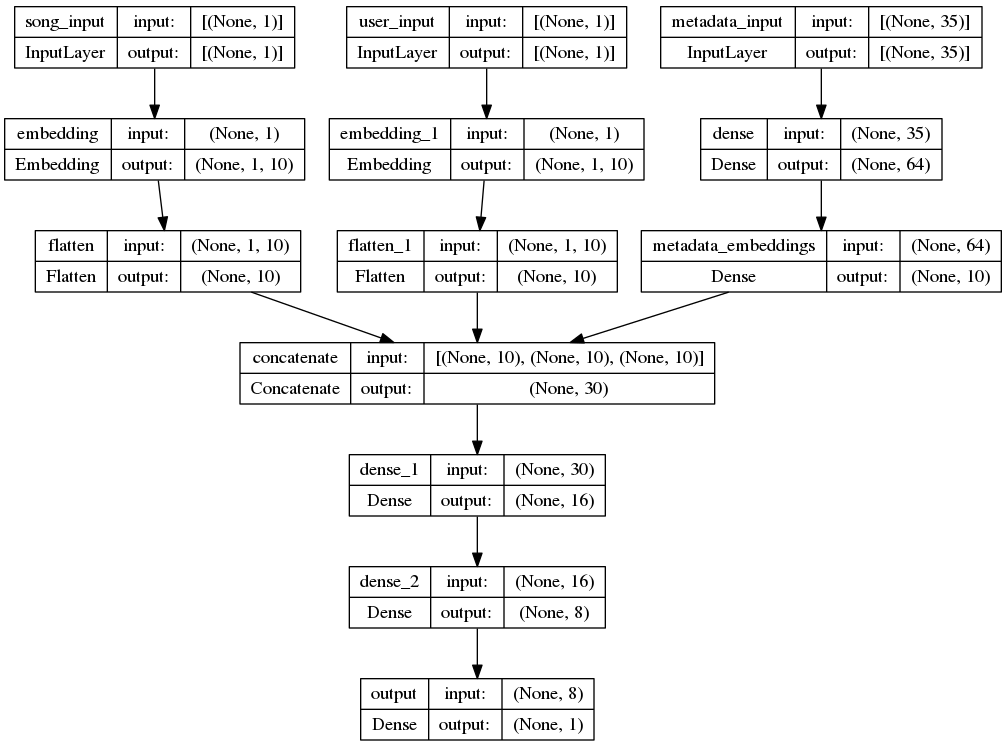

In [53]:
plot_model(model, to_file='model.png', show_shapes = True, show_layer_names = True)

In [54]:
record_model_callback = LambdaCallback(  
    on_batch_end=lambda batch, logs: (
        loss_values.append(logs['loss']),
        acc_values.append(logs['accuracy']),
        rmse_values.append(np.sqrt(logs['root_mean_squared_error']))))

loss_values = []
rmse_values = []
acc_values = []

In [55]:
history = model.fit(
  [song_input, user_input, train_with_meta], train_target, 
  batch_size = 512, 
  epochs = 2, 
  verbose = 1,
  callbacks = [record_model_callback],
  validation_split=0.1
)

Epoch 1/2
12776/12776 [==============================] - 660s 52ms/step - loss: 1.6305 - accuracy: 0.6431 - root_mean_squared_error: 1.2726 - val_loss: 1.5463 - val_accuracy: 0.6429 - val_root_mean_squared_error: 1.2433
Epoch 2/2
12776/12776 [==============================] - 588s 46ms/step - loss: 1.5431 - accuracy: 0.6434 - root_mean_squared_error: 1.2421 - val_loss: 1.5401 - val_accuracy: 0.6429 - val_root_mean_squared_error: 1.2409


In [56]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print("Training accuracy: ", train_acc)
print("Validation accuracy: ", train_acc)

Training accuracy:  [0.6431046724319458, 0.643377423286438]
Validation accuracy:  [0.6431046724319458, 0.643377423286438]


In [57]:
train_pred = model.predict([song_input, user_input, train_with_meta])
train_gt = train_target.values
train_rmse = np.sqrt(np.mean((train_pred - train_gt)**2))
print("Train RMSE: ", train_rmse)

227122/227122 [==============================] - 833s 4ms/step
Train RMSE:  1.2410257927352608


In [58]:
test_pred = model.predict([test_song_input, test_user_input, test_with_meta])
test_gt = test_target.values
test_rmse = np.sqrt(np.mean((test_pred - test_gt)**2))
test_rmse
print("Test RMSE: ", test_rmse)

25236/25236 [==============================] - 95s 4ms/step
Test RMSE:  1.3300739384310485


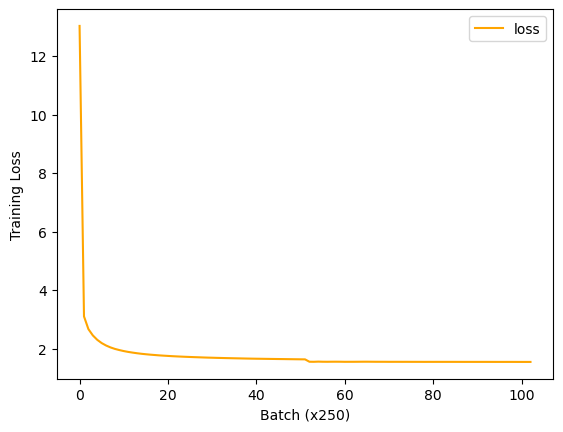

In [59]:
plt_loss_values = loss_values[::250]
plt.plot(np.arange(len(plt_loss_values)), plt_loss_values, label='loss', color = 'orange')
plt.xlabel('Batch (x250)')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

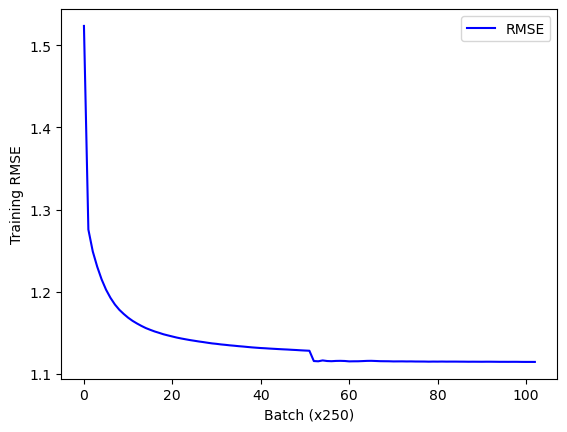

In [60]:
plt_rmse_values = rmse_values[::250]
plt.plot(np.arange(len(plt_rmse_values)), plt_rmse_values, label='RMSE', color='blue')
plt.xlabel('Batch (x250)')
plt.ylabel('Training RMSE')
plt.legend()
plt.show()

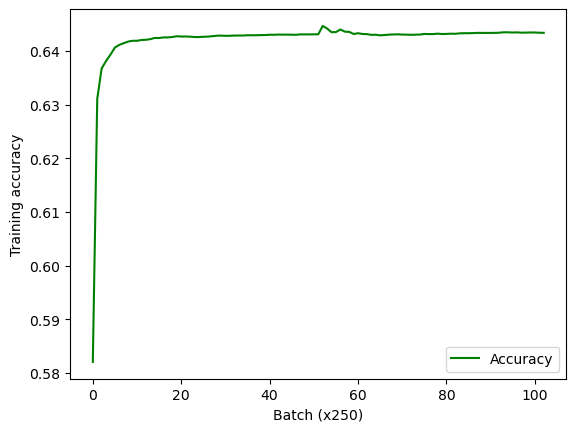

In [61]:
plt_acc_values = acc_values[::250]
plt.plot(np.arange(len(plt_acc_values)), plt_acc_values, label='Accuracy', color='green')
plt.xlabel('Batch (x250)')
plt.ylabel('Training accuracy')
plt.legend()
plt.show()

In [62]:
user_id = 'b80344d063b5ccb3212f76538f3d9e43d87dca9e'
user_id = user_dict[user_id]
print("Encoded user ID: ")
user_id

Encoded user ID: 


638875

In [63]:
song_df = song_data.drop(columns=['user_id', 'play_count', 'playcount_pred'], axis=1)
song_df = song_df.sort_values('song_id', ascending=True)
song_df.drop_duplicates(inplace=True)
song_df.shape

(26267, 8)

In [64]:
song_df = song_df.reset_index(drop=True)
song_df.head(8)

,artist_familiarity,artist_hotttnesss,artist_name,release,song_hotttnesss,song_id,title,duration
0,0.694918,0.485572,vic chesnutt,at the cut,0.627505,0,flirted with you all my life,0.527367
1,0.673095,0.467843,lou rawls,an axelrod anthology 68 70,0.604694,1,for what its worth,0.266451
2,0.788522,0.462833,vivian girls,everything goes wrong,0.759913,2,cant get over you,0.372434
3,0.666821,0.469237,fotos,nach dem goldrausch incl bonus track,0.648218,3,fotos,0.412427
4,0.825674,0.490312,matt costa,songs we sing,0.797340,4,ballad of miss kate,0.501804
5,0.716494,0.510209,blockhead,music by cavelight,0.626613,5,breath and start,0.481030
6,0.685491,0.519208,martina topleybird,the l word the second season,0.734471,6,ilya,0.462371
7,0.819087,0.533117,morcheeba,parts of the process,0.697754,7,rome wasnt built in a day,0.366153


In [65]:
user_df = song_data.sort_values('user_id', ascending=True)

In [66]:
songs_listened = user_df[user_df['user_id'] == user_id]['song_id'].tolist()
unique_songs = song_df['song_id'].unique().tolist()
unique_users = user_df['user_id'].unique().tolist()

In [67]:
to_recommend = song_df[~song_df['song_id'].isin(songs_listened)]
user_list = [user_id]*len(to_recommend)
to_recommend['user_id'] = user_list

/tmp/ipykernel_169343/3653136752.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_recommend['user_id'] = user_list


In [68]:
svd_pred = []
for i, r in to_recommend.iterrows():
    u = r['user_id']
    s = r['song_id']
    preds = svd.predict(u, s).est
    svd_pred.append(preds)
to_recommend['playcount_pred'] = svd_pred

/tmp/ipykernel_169343/755124281.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_recommend['playcount_pred'] = svd_pred


In [69]:
to_recommend.head(8)

,artist_familiarity,artist_hotttnesss,artist_name,release,song_hotttnesss,song_id,title,duration,user_id,playcount_pred
0,0.694918,0.485572,vic chesnutt,at the cut,0.627505,0,flirted with you all my life,0.527367,638875,1.032039
1,0.673095,0.467843,lou rawls,an axelrod anthology 68 70,0.604694,1,for what its worth,0.266451,638875,1.312224
2,0.788522,0.462833,vivian girls,everything goes wrong,0.759913,2,cant get over you,0.372434,638875,1.000000
3,0.666821,0.469237,fotos,nach dem goldrausch incl bonus track,0.648218,3,fotos,0.412427,638875,1.732296
4,0.825674,0.490312,matt costa,songs we sing,0.797340,4,ballad of miss kate,0.501804,638875,1.123033
5,0.716494,0.510209,blockhead,music by cavelight,0.626613,5,breath and start,0.481030,638875,1.111756
6,0.685491,0.519208,martina topleybird,the l word the second season,0.734471,6,ilya,0.462371,638875,1.000000
7,0.819087,0.533117,morcheeba,parts of the process,0.697754,7,rome wasnt built in a day,0.366153,638875,1.202567


In [70]:
inputs = ['user_id', 'song_id', 'artist_name', 'title', 'release', 'duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']
test_input = to_recommend[inputs].copy()

test_text_data = ['artist_name', 'title', 'release']
test_meta_text = to_recommend[test_text_data].copy()

test_meta_text['text'] = test_meta_text.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
corpus = [text.split() for text in test_meta_text['text']]
emb_size = 30
test_model_ft = FastText(sentences=corpus, vector_size=emb_size, window=5, min_count=1, workers=4, sg=0)

test_text_vector = []
for text in test_meta_text['text']:
    vec = np.zeros(emb_size)
    tokens = text.split()
    for token in tokens:
        if token in test_model_ft.wv:
            vec += test_model_ft.wv[token]
    test_text_vector.append(vec)
    
test_text_vector = np.array(test_text_vector)

test_cols = to_recommend[['duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']].values
test_with_meta = np.concatenate((test_text_vector, test_cols), axis=1)

song_col = ['song_id']
user_col = ['user_id']

test_song_input = test_input[song_col].copy()
test_user_input = test_input[user_col].copy()
test_song_input.shape, test_user_input.shape, test_with_meta.shape

((26235, 1), (26235, 1), (26235, 35))

In [71]:
user_playcount_pred = model.predict([test_song_input, test_user_input, test_with_meta])

820/820 [==============================] - 10s 12ms/step


In [72]:
user_playcount_pred.shape

(26235, 1)

In [73]:
to_recommend['final_prediction'] = user_playcount_pred

/tmp/ipykernel_169343/597565698.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_recommend['final_prediction'] = user_playcount_pred


In [74]:
recommendations = to_recommend.sort_values('final_prediction', ascending=False)[:20]
recommendations.head(20)

,artist_familiarity,artist_hotttnesss,artist_name,release,song_hotttnesss,song_id,title,duration,user_id,playcount_pred,final_prediction
20882,0.694914,0.470632,camera obscura,the sweetest thing,0.673070,20671,tougher than the rest,0.392337,638875,2.872306,3.673261
23607,0.710547,0.469098,clutch,strange cousins from the west,0.630525,23369,sleestak lightning,0.391778,638875,2.844985,3.565933
19825,0.796082,0.517772,bright eyes,oh holy fools,0.772797,19621,oh_ you are the roots that sleep beneath my fe...,0.310300,638875,2.582695,3.491818
11363,0.818503,0.517814,smash mouth,smash mouth,0.668656,11231,out of sight,0.277584,638875,2.790997,3.449275
6942,0.712764,0.453508,1997,a better view of the rising moon,0.641647,6855,patience_ prudence album version,0.342393,638875,2.568354,3.301157
5882,0.748720,0.599914,portugal the man,the satanic satanist the majestic majesty delu...,0.726342,5807,guns and dogs acoustic,0.281565,638875,2.502749,3.300836
22399,0.718758,0.504335,sin bandera,sin bandera,0.675576,22163,si me besas,0.459012,638875,2.629365,3.293074
11098,0.800654,0.601700,meat loaf,hang cool teddy bear,0.647220,10966,if it rains,0.420202,638875,2.605339,3.246240
22072,0.716689,0.538178,ash,true love 1980,0.651545,21840,true love 1980,0.442779,638875,2.603351,3.149924
10057,0.789343,0.598934,alan jackson,drive,0.610080,9938,a little bluer than that,0.271551,638875,2.467113,3.079856


In [75]:
print("The top 20 recommendations for the user are: \n\n")
for song_recommendation in recommendations[['title', 'release', 'artist_name']].values:
    print(song_recommendation[0].upper(), "from the album", song_recommendation[1].upper(), "by", song_recommendation[2].upper())

The top 20 recommendations for the user are: 


TOUGHER THAN THE REST from the album THE SWEETEST THING by CAMERA OBSCURA
SLEESTAK LIGHTNING from the album STRANGE COUSINS FROM THE WEST by CLUTCH
OH_ YOU ARE THE ROOTS THAT SLEEP BENEATH MY FEET AND HOLD THE EARTH IN PLACE from the album OH HOLY FOOLS by BRIGHT EYES
OUT OF SIGHT from the album SMASH MOUTH by SMASH MOUTH
PATIENCE_ PRUDENCE ALBUM VERSION from the album A BETTER VIEW OF THE RISING MOON by 1997
GUNS AND DOGS ACOUSTIC from the album THE SATANIC SATANIST THE MAJESTIC MAJESTY DELUXE EDITION by PORTUGAL THE MAN
SI ME BESAS from the album SIN BANDERA by SIN BANDERA
IF IT RAINS from the album HANG COOL TEDDY BEAR by MEAT LOAF
TRUE LOVE 1980 from the album TRUE LOVE 1980 by ASH
A LITTLE BLUER THAN THAT from the album DRIVE by ALAN JACKSON
IF YOU LEAVE ME NOW REMASTERED LP VERSION from the album RHINO HIFIVE CHICAGO by CHICAGO
WIND UP DEMO from the album KILL THE HOUSE LIGHTS by THURSDAY
MIDNIGHT RIDER from the album PLAYLIST THE B